# Segmentation of Medical Scans using Variational VAE's
This notebook goes through the process of creating a pytorch-compatible dataset, and setting up a model for segmentation of tumors in various organs. It enables reproduceability of our final model and testing results.

## 1. Setup
We import some necessary libraries

In [1]:
# For ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim
from torch import Tensor
import torchvision.transforms as Transform
from torch.utils.data import Dataset

# For reading raw data.
import json
import nibabel as nib

# For displaying and evaluating results.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# For monitoring resource-usage and progress.
from tqdm import tqdm # Install ipywidgets to remove warning.
import os, sys, psutil
from os.path import join, exists

And check if our GPU is available, while also retrieving some system stats. We need a lot of RAM, because our selected datasets are very large.

In [2]:
# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)

available_ram = round(psutil.virtual_memory()[0]/1000000000,2)
print('RAM: ' + str(available_ram) + 'GB')

Using cuda
NVIDIA GeForce GTX 1070
CUDA version: 11.7
RAM: 16.74GB


We setup up some global constants.

In [3]:
root_dir = '../' # Location of project, relative to the working directory.
raw_data_dir = join(root_dir, 'raw_data')
prep_data_dir = join(root_dir, 'augmenteddata')

cmap_seg = ListedColormap(['none', 'red']) # For drawing tumors in red.

And some utility functions.

In [4]:
def superimpose(image, label):
    plt.imshow(image, cmap='gray')
    plt.imshow(label, cmap=cmap_seg)
    plt.show()

We preprocess and format datasets from raw data for each specified organ, using the above function. We save progress after each organ is completed. Can be interrupted and resumed at any time, and accounts for progress, which has already been made. We define a function which loads and stores our data in the proper formatting. As the datasets are huge and have to concatenate each set of 240 slices to the previous, we monitor progress and RAM-usage.

In [5]:
def prep_data(organ, type, resolution):
    with open(join(raw_data_dir, organ, 'dataset.json')) as f:
        manifest = json.load(f)['training']
    
    bar = tqdm(total=len(manifest))
    bar.set_description('Prepping ' + organ + ' ' + type + 's')
    
    resize = Transform.Resize((resolution, resolution))

    try: 
        images = torch.zeros((0, resolution, resolution))

        for entry in manifest:
            bar.set_postfix(**{'RAM':round(psutil.virtual_memory()[3]/10e8, 2)})
            bar.update()

            nii_img = nib.load(join(raw_data_dir, organ, entry[type][2:]))

            # Convert to numpy array, then pytorch tensor.
            nii_data = Tensor(nii_img.get_fdata())

            # Scale between 0 and 1.
            nii_data -= nii_data.min()
            nii_data /= nii_data.max()
            nii_data = nii_data.permute(2, 0, 1) # (slice, rows, columns)
            nii_data = resize(nii_data)
            images = torch.cat((images, nii_data), 0)
        
        torch.save(images, join(prep_data_dir, organ + '_' + type + '_slices_' + str(resolution) + '.pt'))

    except KeyboardInterrupt:
        print('Manually stopped.')
    
    bar.close()

We call the preprocessor function for the organs, we wish to train on.

In [6]:
lod = 2**8 # Level of detail. An easier way to denote resolution.
resolution = lod # 2**8 = 256

organs = ['spleen'] # Simply add to this list.
do_prep = False

if do_prep:
    for organ in organs:
        prep_data(organ,'image',resolution)
        prep_data(organ,'label',resolution)
else:
    print('Data already prepped.')

Prepping spleen labels: 100%|██████████| 41/41 [00:18<00:00,  2.23it/s, RAM=2.96]


## 2. Creating a pytorch dataset
We define a custom dataset class.

In [9]:
class CT_Dataset(Dataset):
    def __init__(self, path, organ, resolution):
        self.images = torch.load(join(path, organ + '_image_slices_' + str(resolution) + '.pt'))
        
        self.labels = torch.load(join(path, organ + '_label_slices_' + str(resolution) + '.pt'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def show_datapoint(self, index):
        image, label = self.__getitem__(index)
        superimpose(image, label)

We check if the dataset functions directly by retrieving and displaying a single datapoint. One must specify the organ and the resolution of the images.

In [11]:
# Be careful with running this, as the training_set 
# variable will take up a lot of space in RAM.

training_set = CT_Dataset(prep_data_dir, 'spleen', resolution)

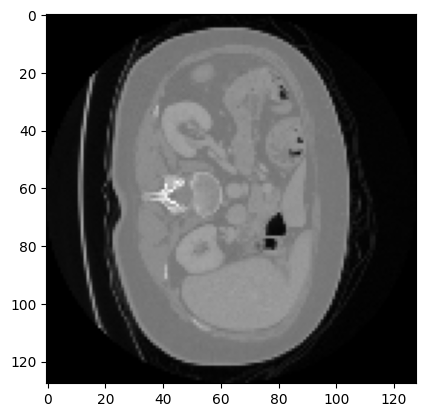

In [12]:
training_set.show_datapoint(900)

## 3. Defining our model architecture 